In [137]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

## 1. Central Limit Theorem

### Population Distribution

In [2]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.power(x - position, 2.) / (2 * np.power(deviation, 2.))) + height) * altitude

# FUNCTION 3
def winner(x, position = None):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def sine(x, position = 0.5):
    return (np.sin(10*x + position))*0.5+0.5

functions = [logit, gauss, winner, sine]

In [3]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y:
            return x
        return generateDistribution(function)
    else:
        return np.array([generateDistribution(function) for _ in range(size)])

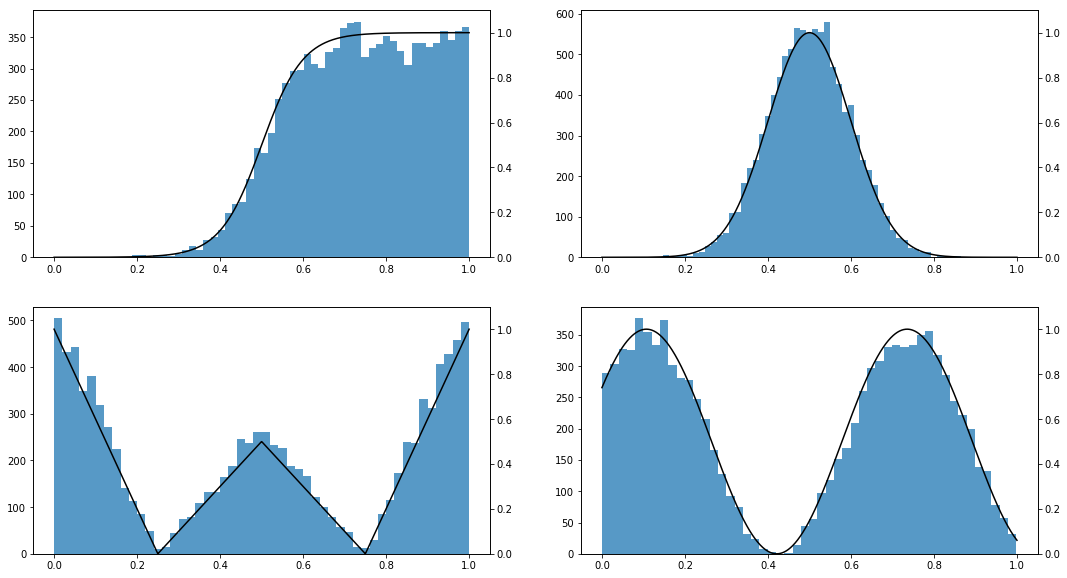

In [4]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
mean, sd = [], []
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    population = generateDistribution(f, 10000)
    ax.hist(population, bins=50, alpha=0.75)
    mean.append(population.mean())
    sd.append(np.std(population))
    ax2.plot(x, f(x), '-k'); ax2.set_ylim(0,1.1)
    #ax2.fill_between(x, 0, f(x), alpha=0.2)
plt.show()

### Sampling Distribution

In [5]:
SIZE = 5
SAMPLES = 10000
ZSCORE = 1.96

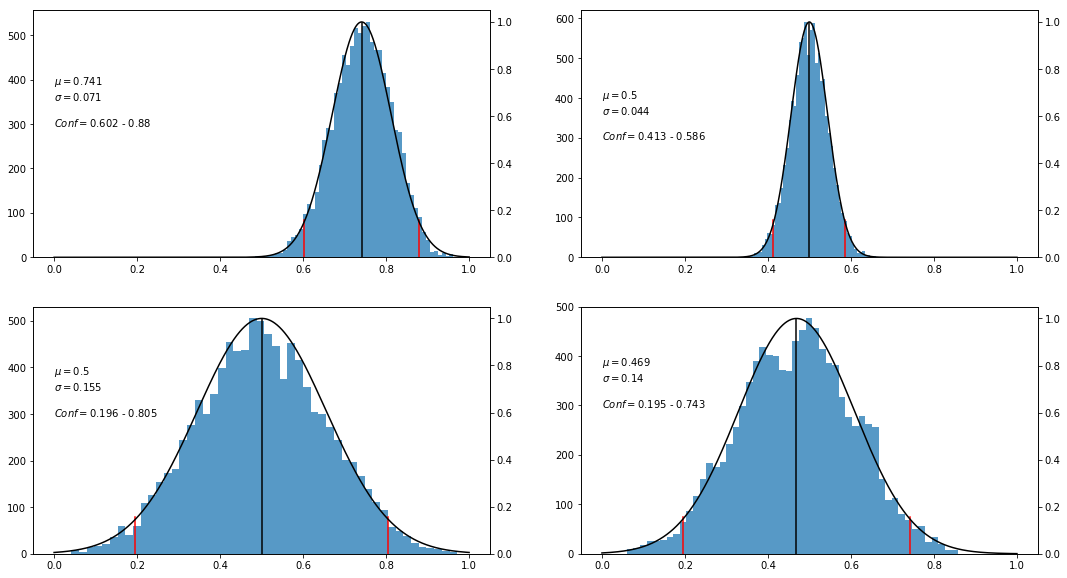

In [6]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    
    samplemeans = [generateDistribution(f, SIZE).mean() for _ in range(SAMPLES)]
    se = sd[i] / np.sqrt(SIZE)
    ci = (mean[i]-ZSCORE*se, mean[i]+ZSCORE*se) # = norm.interval(0.95, mean[i], se)
    
    ax.hist(samplemeans, bins=50, alpha=0.75)
    ax2.plot(x, gauss(x, mean[i], se), '-k'); ax2.set_ylim(0,)
    ax.text(0, 300, r'$\mu =$' + str(round(mean[i], 3)) + '\n' + r'$\sigma =$' + str(round(se, 3)) +
            '\n\n' + r'$Conf = $' + str(round(ci[0], 3)) + ' - ' + str(round(ci[1], 3)))
    
    ax.axvline(x=ci[0], color='r', ymax=0.15)
    ax.axvline(x=ci[1], color='r', ymax=0.15)
    ax.axvline(x=mean[i], color='k', ymax=0.95)
plt.show()

## 2. Significancy tests

In [136]:
from scipy.stats import norm, t, f, ttest_1samp, ttest_rel, ttest_ind, zscore

### Percentage tables

<img src="img/z-table.jpg" style="width:530px;display:inline-block;"/>
<img src="img/t-table.jpg" style="width:370px;display:inline-block;vertical-align:top"/>

Z-scores

In [7]:
ZSCORE = 1.96
print('Get Z-score from p-statistic: ', norm.ppf(.975))
print('Get p-statistic from Z-score: ', norm.cdf(ZSCORE), norm.sf(ZSCORE))
print()
print('Get CI from p-statistic: ', norm.interval(0.95))

Get Z-score from p-statistic:  1.95996398454
Get p-statistic from Z-score:  0.975002104852 0.0249978951482

Get CI from p-statistic:  (-1.959963984540054, 1.959963984540054)


P-scores

In [8]:
TSCORE = 1.65
DF = 999
print('Get T-score from p-statistic: ', t.ppf(.95, DF))
print('Get p-statistic from T-score: ', t.cdf(TSCORE, DF), t.sf(TSCORE, DF))
print()
print('Get CI/critical values from p-statistic: ', t.interval(0.95, DF))

Get T-score from p-statistic:  1.64638034543
Get p-statistic from T-score:  0.950371357874 0.0496286421255

Get CI/critical values from p-statistic:  (-1.9623414611334487, 1.9623414611334487)


### Helper functions

In [159]:
def plotGauss(mu0, se, cv, mean, title, apa=''):
    fig = plt.figure(figsize=(9, 5))
    x = np.linspace(mu0 - 4*se, mu0 + 4*se, num=1000)
    plt.plot(x, gauss(x, mu0, se), '-k'); plt.ylim(0,1.2)
    #plt.fill_between(x, 0, gauss(x, mu0, se), alpha=0.2)
    
    # Sample mean
    plt.axvline(x=mean, color='r', ymax=gauss(mean, mu0, se)*0.83)
    plt.text(mean, gauss(mean, mu0, se)+.1, r'$\overline{x} =$' + str(round(mean, 3)))

    # Critical values
    ci = mu0 + cv * se
    plt.fill_between(x, 0, gauss(x, mu0, se), where=x<ci[0], color='r')
    plt.text(ci.item(0), 0.23, r'$cv =$' + str(round(ci.item(0), 3)))
    if ci.size == 2:
        plt.fill_between(x, 0, gauss(x, mu0, se), where=x>ci[1], color='r')
        plt.text(ci[1], 0.23, r'$cv =$' + str(round(ci[1], 3)))    
    
    # Standard errors
    for i in np.linspace(-3, 3, 7):
        plt.axvline(i*se+mu0, color='k', ymax=gauss(i*se+mu0, mu0, se)*0.83)
    
    plt.text(mu0, 1.1, r'$\mu_0 =$' + str(round(mu0, 3)))
    plt.text(mu0+se, 0.68, r'$\sigma =$' + str(round(se, 3)))
    plt.text(mu0+(-4*se), 0.9, apa)

    plt.title(title)
    plt.show()
    
def apa(df, T, p, kind):
    s = 't('+ str(df)+') = ' + str(round(T, 2))
    s += ', p = ' + str(round(p, 2)) + ', ' + kind
    return s

### One-sampled Z-test
Is there a significant difference between a sample and a given population distribution.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}\\
z &= \frac{  {\overline{x} - \mu_0}}{{\sigma}}
\end{align}

In [160]:
# Descriptive statistics
sample = norm.rvs(loc=7, scale=2, size=10)
mean = np.mean(sample)
mu0, sigma = 8, 2
print(mean)
print(sample)

7.44749177949
[  9.20648372   6.37079621   3.78901921   6.28097901   6.4208377
   9.21059305   7.13495917  10.52595205   8.69596834   6.83932934]


In [161]:
# Inferential statistics
Z = (mean - mu0) / sigma
p = norm.cdf(Z)*2
cv = np.array(norm.interval(.95))
print(Z, p, cv)

-0.276254110255 0.782352899582 [-1.95996398  1.95996398]


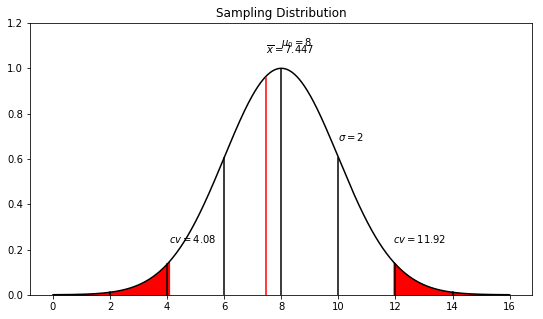

In [162]:
plotGauss(mu0, sigma, cv, mean, 'Sampling Distribution')

### One-sampled t-test
Is there a significant difference between a sample and a given population mean.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&s = \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n}}
&&t = \frac{  {\overline{x} - \mu_0}}{s_e}\\
d &= \frac{  {\overline{x} - \mu_0}}{s}
&&r^2 = \frac{t^2}{t^2+df}
\end{align}

In [163]:
# Descriptive statistics
sample = norm.rvs(loc=6, scale=2, size=15)
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
print(mean, sd)
print(sample)

5.91113528773 1.74655879146
[ 7.28789194  7.90519091  3.06098993  5.91649416  4.52727013  9.78932581
  6.49477434  7.04319501  5.22280885  6.45538739  5.44824457  5.43113185
  5.41253108  6.17413871  2.49765463]


In [164]:
# Inferential statistics
mu0 = 5.5
cv = np.array(t.interval(.95, n-1)) # t.ppf(.05, 24) one-tailed
se = sd / np.sqrt(n)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
print(T, p, cv)
print(ttest_1samp(sample, mu0))

0.911689964397 1.62263661823 [-2.14478669  2.14478669]
Ttest_1sampResult(statistic=0.88077618332024921, pvalue=0.39330850653249794)


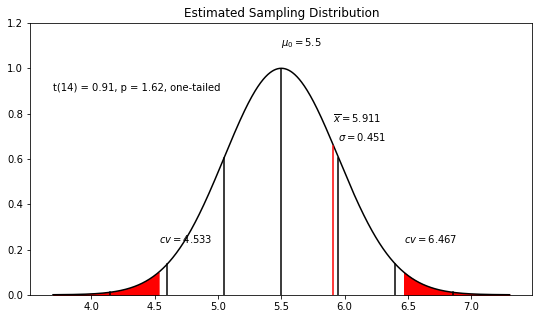

In [165]:
plotGauss(mu0, se, cv, mean, 'Estimated Sampling Distribution', apa(n-1, T, p, 'one-tailed'))

### Paired sampled t-test
Is there a significant difference between two dependent samples.

\begin{align}
x_i &= y_i - z_i\\
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&s = \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n}}
&&t = \frac{  {\overline{x} - \mu_0}}{s_e}
\end{align}

In [166]:
# Descriptive statistics
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=15)
sample = sample1 - sample2
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
print(mean, sd)
print(sample)

-0.868252016688 2.88187185052
[ 4.10947728 -2.05326708 -7.14620423  0.08121975  0.5907314  -0.47504492
 -3.23129458 -2.40413806 -0.88620283 -1.71518356  0.40015586 -1.82323572
 -3.67556229  0.08789664  5.1168721 ]


In [167]:
# Inferential statistics
mu0 = 0 # No difference
se = sd / np.sqrt(n-1)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
cv = np.array(t.interval(.95, n -1))
print(T, p, cv)
print(ttest_rel(sample1, sample2))

-1.12728869996 0.27857109676 [-2.14478669  2.14478669]
Ttest_relResult(statistic=-1.1272886999607403, pvalue=0.27857109675952801)


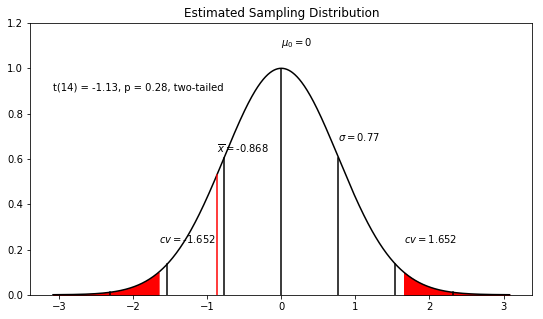

In [168]:
plotGauss(mu0, se, cv, mean, 'Estimated Sampling Distribution', apa(n-1, T, p, 'two-tailed'))

### Two sampled t-test
Is there a significant difference between independent samples.

\begin{align}
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&\overline{y} = \frac{1}{m} \sum^n_{i=1}{y_i}\\
s_x &= \sqrt{{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}}} 
&& s_y = \sqrt{{\frac{ \sum^m_{i=1}{(y_i - \overline{y})^2} }{m-1}}} \\
s_p &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2}}
&&s_e = s_p\sqrt{\frac{1}{n}+\frac{1}{m}}\\
s_e &= \sqrt{\frac{s_x^2}{n}+\frac{s_y^2}{m}}
&&t = \frac{  {\overline{x} - \overline{y}}} {s_e}
\end{align}

In [169]:
# Descriptive statistics
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=10)
n, mean1, sd1 = len(sample1), np.mean(sample1), np.std(sample1)
m, mean2, sd2 = len(sample2), np.mean(sample2), np.std(sample2)
print(mean1, sd1, mean2, sd2)
print(sample1)
print(sample2)

5.22965898694 1.9557279838 6.66104983985 1.60350650097
[ 2.62138285  2.94381787  3.53486605  5.38970985  8.08467835  9.74096624
  4.49254705  4.59966232  5.445057    4.86751223  6.91812868  2.48673341
  6.45958398  4.77494553  6.08529341]
[ 5.14640847  8.371948    9.66314716  7.83514989  4.68908922  6.46406745
  4.76964332  5.87637197  5.93098009  7.86369283]


In [170]:
# Inferential statistics
mu0 = 0
#sp = np.sqrt(((n-1) * np.power(sd1, 2) + (m-1) * np.power(sd2, 2)) / (n + m - 2))
#se = sp * np.sqrt((1/float(n)+1/float(m)))
se = np.sqrt((np.power(sd1, 2) / n) + (np.power(sd2, 2) / m))
T = (mean1 - mean2) / se
p = t.cdf(T, n+m-2)*2
cv = np.array(t.interval(.95, n + m - 2))
print(T, p, cv)
print(ttest_ind(sample1, sample2))

-2.00020535451 0.0574208889896 [-2.06865761  2.06865761]
Ttest_indResult(statistic=-1.8447409848674543, pvalue=0.077992622411949458)


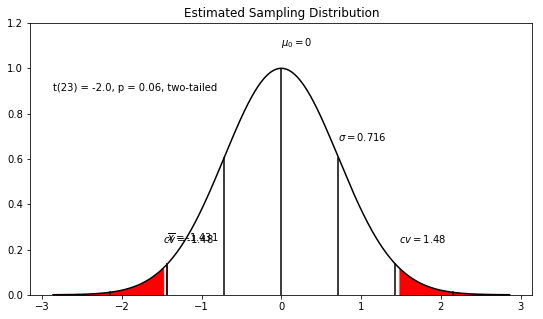

In [171]:
plotGauss(mu0, se, cv, mean1 - mean2, 'Estimated Sampling Distribution', apa(n+m-2, T, p, 'two-tailed'))

### Cohen's d and r squared

\begin{align}
s_p &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2}}\\
d &= \frac{  {\overline{x} - \overline{y}}} {s_p}
&r^2 = \frac{t^2}{t^2+df}
\end{align}

## 3. Analysis of variance - Anova

In [172]:
from scipy.stats import f, f_oneway

Is there a significant difference between any two of more independent samples.

\begin{align}
F &= \frac{between\ group\ variability}{within\ group\ variablilty} 
= \frac{\sum^k_{k=1}{n_k(\overline{x}_k-\overline{x}_G)^2}\ /\ (k-1)}{\sum^k_{k=1}{(\overline{x}_i-\overline{x}_k)^2}\ /\ (N-k)}
= \frac{SS_{between}\ /\ df_{between}}{SS_{within}\ /\ df_{within}}
= \frac{MS_{between}}{MS_{within}}
\end{align}

Descriptive statistics

In [173]:
samples = np.array([norm.rvs(m, s, n) for (m, s, n) in [(2, 2, 100), (10, 5, 100), (30, 2, 100)]])
statistics = [(np.mean(sample), np.std(sample), len(sample)) for sample in samples]
statistics

[(1.8035961489414658, 1.6888761211318326, 100),
 (10.089737986625343, 4.7420562364381729, 100),
 (29.798345513171672, 2.0193074014059036, 100)]

* As the between group variability increases, the F-statistic increases as well.
* As the within group variability increases, the F-statistic decreases.

|Sample 1   |Sample 2   |Sample k   | Grand mean  |
|--:|--:|--:|--:|
| $x_1$  | $x_1$  |$x_1$  |   |   
| $x_2$  | $x_2$  |$x_2$  |   |   
| $x_3$  | $x_3$  |$x_3$  |   |   
| $x_{n}$  | $x_{n}$  |$x_{n}$  |   |   
|  $\overline{x}_k$ | $\overline{x}_k$  | $\overline{x}_k$  | $\overline{x}_G$  |

Inferential statistics

In [174]:
grandMean = samples.flatten().mean()
sampleMeans = np.array([x[0] for x in statistics])
sampleSizes = np.array([x[2] for x in statistics])

In [175]:
ssb = np.sum(np.power(sampleMeans - grandMean, 2) * sampleSizes)
ssw = np.sum([np.power(np.array(xi)-xk, 2) for xi, xk in zip(samples, sampleMeans)])
dfb = len(sampleSizes) - 1
dfw = len(samples.flatten()) - len(sampleSizes)

In [176]:
F = (ssb / dfb) / (ssw / dfw)
p = f.sf(F, dfb, dfw)
print(F, p)
print(f_oneway(samples[0], samples[1], samples[2]))

2087.88676669 1.2406854094e-175
F_onewayResult(statistic=2087.8867666871383, pvalue=1.2406854094013245e-175)


Critical values, link to <a href="http://www.socr.ucla.edu/applets.dir/f_table.html">F-table</a>.

In [177]:
Fcrit = f.ppf(0.95, dfb, dfw)
print(Fcrit, 'Null hypothesis rejected?', F > Fcrit)

3.02615336857 Null hypothesis rejected? True


/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1415: RuntimeWarning: divide by zero encountered in log
  lPx = m/2 * log(m) + n/2 * log(n) + (n/2 - 1) * log(x)
/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1415: RuntimeWarning: invalid value encountered in multiply
  lPx = m/2 * log(m) + n/2 * log(n) + (n/2 - 1) * log(x)


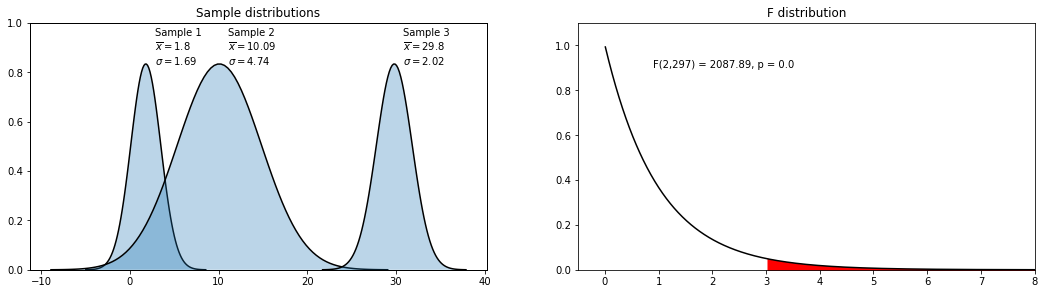

In [179]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

for i, (m, s, n) in enumerate(statistics):
    ax = ax1.twinx()
    x = np.linspace(m-4*s, m+4*s, num=100)
    ax.plot(x, gauss(x, m, s), '-k')
    ax.fill_between(x, 0, gauss(x, m, s), alpha=0.3)
    ax.text(m+1, 1., 'Sample '+ str(i+1)+'\n' +
             r'$\overline{x} =$' + str(round(m, 2)) + '\n' + 
             r'$\sigma =$' + str(round(s, 2)))
    ax.set_ylim(0,1.2); ax.get_yaxis().set_visible(False)
ax1.set_title('Sample distributions')

x = np.linspace(0, 8, num=1000)
ax2.plot(x, f.pdf(x, dfb, dfw), '-k')
#ax2.fill_between(x, 0, f.pdf(x, dfb, dfw), alpha=0.2)
ax2.fill_between(x, 0, f.pdf(x, dfb, dfw), where=x>Fcrit, color='r')
ax2.axvline(x=F, color='r', ymax=f.pdf(F, dfb, dfw)*0.9)
ax2.set_ylim(0,1.1); ax2.set_xlim(-.5,8)
ax2.set_title('F distribution')

s = 'F('+ str(dfb)+','+str(dfw)+') = ' + str(round(F, 2)) + ', p = ' + str(round(p, 2))
ax2.text(0.9, 0.9, s)

plt.show()

### Multiple Comparison Test - Tuckey's HSD

\begin{align}
Tuckey's\ HSD = q\ \sqrt{\frac{MS_{within}}{n}}
= q\ \frac{s_p}{\sqrt{n}}
\end{align}

Critical values, link to [Q-table](https://www2.stat.duke.edu/courses/Spring98/sta110c/qtable.html). If mean differences exceeds critical value, variables are honestly significantly different.

In [180]:
msw = ssw / dfw
hsd = 3.34* np.sqrt(msw / sampleSizes[0])
hsd

1.0511566671847576

In [183]:
print(sampleMeans[2] - sampleMeans[1])
print(sampleMeans[2] - sampleMeans[0])
print(sampleMeans[1] - sampleMeans[0])

19.7086075265
27.9947493642
8.28614183768


### Cohen's d and $\eta$ squared test

\begin{align}
d &= \frac{  {\overline{x} - \overline{y}}} {\sqrt{{MS_{within}}}} = \frac{  {\overline{x} - \overline{y}}} {s_p}\\\\
\eta &= \frac{SS_{between}}{SS_{between} + SS_{within}}
\end{align}

In [184]:
den = np.sqrt(ssw / dfw)
d1 = (sampleMeans[2] - sampleMeans[1]) / den
d2 = (sampleMeans[2] - sampleMeans[0]) / den
d3 = (sampleMeans[1] - sampleMeans[0]) / den
print(d1, d2, d3)

6.26231571312 8.8951976233 2.63288191017


In [185]:
eta = ssb / (ssb + ssw)
print(eta)

0.933598247757


## 4. Correlation

In [77]:
from scipy.stats import pearsonr, t

$r^2$ is the percentage of the variation in $y$ explained by the variation in $x$. 

$t$ is used in a t-test to verify whether $\rho$ (the estimated population correlation) expresses correlation.

\begin{align}
r &= \frac{Cov\ (x,y)}{s_x\ s_y}
= \frac{\sum_{i=1}^n{(x_i - \overline{x})(y_i - \overline{y})\ /\ (n - 1)}}{{s_x\ s_y}} \\\\
t &= \frac{r\sqrt{df}}{1 - r^2} &df = n-2
\end{align}

Descriptive statistics

In [132]:
sample1 = norm.rvs(10, 2, 200)
sample2 = (sample1 + norm.rvs(0, 1.5, 200)) * -10
n, mean1, sd1 = len(sample1), np.mean(sample1), np.std(sample1)
m, mean2, sd2 = len(sample2), np.mean(sample2), np.std(sample2)
print(mean1, sd1)
print(mean2, sd2)

9.93899051297 1.94984466025
-100.65727608 25.0166954716


Inferential statistics

In [133]:
r = (((sample1 - mean1) * (sample2 - mean2)).sum() / (n - 1)) / (sd1 * sd2)
r = (n * (sample1*sample2).sum() - sample1.sum()*sample2.sum()) / np.sqrt((n*np.power(sample1, 2).sum() - np.power(sample1.sum(), 2)) * (n*np.power(sample2, 2).sum() - np.power(sample2.sum(), 2)))
T = (r * np.sqrt(n-2)) / (1 - np.power(r, 2))
p = t.sf(T, n-1)
slope = r * sd2 / sd1
intercept = mean2 - slope * mean1
print(r, T, p)
print(pearsonr(sample1, sample2))
print(slope, intercept)

-0.793078290459 -30.0776115877 1.0
(-0.79307829045945355, 1.6733894683372589e-44)
-10.175271129 0.474647138772


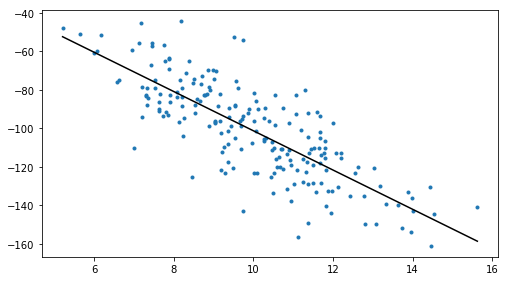

In [138]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(221)
ax.scatter(sample1, sample2, marker='.')
x = np.linspace(min(sample1), max(sample1), num=1000)
ax.plot(x, slope * x + intercept, color='k')
plt.show()